# Performance of baseline model over multiple influenza seasons
We will analyze the performance of the baseline model for seasons from 2005NH to 2021NH.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import utilities   # self defined functions
import model_utilities   # self defined models
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder

# (for reproduciblility) fix the randomly generated numbers
SEED = 100
np.random.seed(SEED)

## Variables

In [2]:
mut_mat     = "binary"   # mutation matrix
Seasons     = [str(year)+s for year in range (2005, 2021) for s in ["NH", "SH"]] + ["2021NH"] # seasons from 2005NH to 2021NH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 # 'virus',   # virus avidity
                 # 'serum',   # antiserum potency
                 # 'virusPassCat',
                 # 'serumPassCat'
                 ]   # metadata features

metadata   = 'no metadata'   # label to record which metadata is being used
model_name = 'baseline'   # the type of model to be used

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig2b_seasonal_performance_baselineModel/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn  = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
train_fn = path_result + "SuppFig2b_trainScores_baseline.csv"   # to save performance scores for training dataset
test_fn  = path_result + "SuppFig2b_testScores_baseline.csv"   # to save performance scores for test dataset
fig_fn   = path_result + 'SuppFig2b_baseline_seasons_MAE_scatterplot.svg'   # to save figure

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [ ]:
data = pd.read_csv(data_fn, converters={"seq_diff": literal_eval})

## Performance of the model
- For each season from 2005NH to 2021NH
    - Split the data into training and test datasets
    - Prepare encoded inputs (genetic difference and metadata features)
    - Train and test the model
    - Compute predictive performance
    - Save the predictions
- Compute average predictive performance

In [ ]:
# to collect actuals and predictions for micro-averaged scores over all seasons
actual_train_all  = {}
predict_train_all = {}

actual_test_all  = {}
predict_test_all = {}


# loop through each season
for season in Seasons:
    print("Season: ", season)

    '''
    Train Test Split
        - based on seasonal framework
        - Train: past virus isolates paired with past sera
        - Test: circulating virus isolates paired with past sera
    '''
    ind_train, ind_test = utilities.seasonal_trainTestSplit(data.copy(), season)
    
    # training dataset
    data_train = data.iloc[ind_train].copy()
    data_train.reset_index(drop=True, inplace=True)
    
    # test dataset
    data_test = data.iloc[ind_test].copy()
    data_test.reset_index(drop=True, inplace=True)


    '''
    Input features (genetic difference)
    '''
    # training dataset
    X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                           index=data_train.index,
                           columns=HA1_features)
    X_train.fillna(0, inplace=True)   # replace nan with 0
    
    # test dataset
    X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                           index=data_test.index,
                           columns=HA1_features)
    X_test.fillna(0, inplace=True)   # replace nan with 0
    
    
    '''
    Input features (metadata features)
    '''
    X_train_meta = data_train[meta_features].fillna('None').astype('str')
    X_test_meta  = data_test[meta_features].fillna('None').astype('str')
    
    
    # one hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_meta = ohe.fit_transform(X_train_meta).toarray()
    X_test_meta  = ohe.transform(X_test_meta).toarray()
      
    X_train = np.hstack((X_train.values, X_train_meta))
    X_test  = np.hstack((X_test.values, X_test_meta))


    del X_train_meta, X_test_meta
        
    
    '''
    Training and Testing
    '''
    # baseline model
    model = getattr(model_utilities, f"model_{model_name}")
    results = model(X_train,
                    data_train.nht.values,
                    X_test = X_test)
    
    
    '''
    Training Scores
    '''
    cols       = ['mut_mat', 'model', 'metadata', 'season']
    col_values = [mut_mat, model_name, metadata, season]
    utilities.compute_scores(data_train.nht.values, results['pred_train'], train_fn, col=cols, col_val=col_values)
    
    
    '''
    Test Scores
    '''
    utilities.compute_scores(data_test.nht.values, results['pred_test'], test_fn, col=cols, col_val=col_values)
    
    
    '''
    Save actuals and predictions
    '''
    actual_train_all[f'{season}']  = data_train.nht.values
    predict_train_all[f'{season}'] = results['pred_train']
    
    actual_test_all[f'{season}']  = data_test.nht.values
    predict_test_all[f'{season}'] = results['pred_test']
    
    #################
    # End season loop
    #################


'''
Micro-average over seasons
'''
actual_train  = np.concatenate(list(actual_train_all.values()))
predict_train = np.concatenate(list(predict_train_all.values()))

actual_test  = np.concatenate(list(actual_test_all.values()))
predict_test = np.concatenate(list(predict_test_all.values()))


# Training scores
col_values = [mut_mat, model_name, metadata, 'Average']
utilities.compute_scores(actual_train, predict_train, train_fn, col=cols, col_val=col_values)


# Test scores
utilities.compute_scores(actual_test, predict_test, test_fn, col=cols, col_val=col_values)

print("Training and testing completed")

## Imports and configuration for plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read test scores of baseline model and prepare data for plots

In [5]:
scores = pd.read_csv(test_fn)

# remove average score over seasons
scores = scores[scores.season != 'Average']

dummy_scores = pd.DataFrame(None, index=range(4), columns=scores.columns)
dummy_scores.loc[0, ["season", "MAE"]] = ["2003NH", -1]
dummy_scores.loc[1, "season"] = "2003SH"
dummy_scores.loc[2, "season"] = "2004NH"
dummy_scores.loc[3, "season"] = "2004SH"

scores = dummy_scores.append(scores, ignore_index=True)

## Plot MAE per season

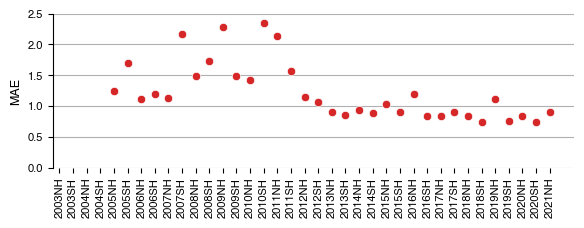

In [6]:
fig, ax = plt.subplots(figsize=(6.73,2))

sns.scatterplot(x='season', y='MAE', data=scores,
                color='C3', ax=ax)

# configurations for figure 
ax.set_axisbelow(True)
ax.grid(axis='y')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(bottom=0, top=2.5)
ax.set_xlabel("")
ax.set_ylabel("MAE", fontsize=9)
ax.set_xlim(left=-0.5)

sns.despine(trim=True, bottom=True)

# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')